# 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：猫狗大战

### 项目内容

本项目拟采用 keras 结合 tensorflow 作为后端来完成编码。具体流程如下：

* [Step 1](#step1): 数据预处理
* [Step 2](#step2): 搭建模型
* [Step 3](#step3): 模型训练与评估
* [Step 5](#step4): 模型可视化

---
<a id='step1'></a>
## 步骤 1: 数据预处理

### 1.1 文件及目录处理
首先从 Kaggle 网站下载本项目所需的训练集文件 train.zip 和测试集文件 test.zip，分别解压放置于 data 目录下。检索发现测试集中的图片文件名按猫狗分别附加有 "dog" 或者 "cat" 前缀。为了使用 sklearn.datasets.load_files 以及 flow_from_directory 等工具，需要将测试集的图片按猫和狗分为两个目录存储。

为了节省空间，为每个图片创建符号链接，分别放在其类别对应的目录下：

In [9]:
import os

# unzip files, make directries
if os.path.exists('all.zip') and not (os.path.isdir('data')):
    os.system('unzip -o all.zip; unzip -o train.zip; unzip -o test.zip')
    os.system('mkdir data; mv train test data')

# make symbol links
if not os.path.exists('data/train2'):
    os.system('mkdir -p data/train2/dog data/train2/cat')
    for filename in os.listdir('data/train'):
        if 'dog' in filename:
            os.symlink('../../train/%s' % filename, 'data/train2/dog/%s' % filename)
        else:
            os.symlink('../../train/%s' % filename, 'data/train2/cat/%s' % filename)

if not os.path.exists('data/test2'):
    os.mkdir('data/test2')
    os.symlink('../test/', 'data/test2/test')

经过处理后，最终目录层级组织如下：

```
data  
├── test  
│   ├── 1.jpg
│   ├── 2.jpg
│   ├── .....  
│   └── 12500.jpg
├── test2  
│   └── test -> ../test
├── train 
│   ├── cat.1.jpg
│   ├── .....  
│   ├── cat.12500.jpg
│   ├── dog.1.jpg
│   ├── .....  
│   └── dog.12500.jpg
└── train2  
    ├── cat  
    │   ├── cat.1.jpg -> ../../train/cat.1.jpg
    │   ├── cat.2.jpg -> ../../train/cat.2.jpg
    │   ├── ......  
    │   └── cat.12500.jpg -> ../../data/cat.12500.jpg
    └── dog  
        ├── dog.1.jpg -> ../../train/dog.1.jpg
        ├── dog.2.jpg -> ../../train/dog.2.jpg
        ├── ......  
        └── dog.12500.jpg -> ../../train/dog.12500.jpg
```

### 1.2 数据集探索

#### 1.2.1 统计训练集大小和测试集大小

In [7]:
import os, cv2
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.applications import Xception

%matplotlib inline

# define function to load train dataset
def load_train_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 2) #one-hot encode
    return paths, targets

# load train datasets
# train_files_targes are one-hot encoded for softmax, and train_files_lables for sigmod
train_files_names = os.listdir('data/train')
train_files_paths, train_files_targes = load_train_dataset('data/train2')
train_files_labels = [1 if 'dog' in name else 0 for name in train_files_paths]

train_dogs_paths = [path for path in train_files_paths if 'dog' in path]
train_cats_paths = [path for path in train_files_paths if 'cat' in path]

# load test dataset
test_files_names = os.listdir('data/test')
test_files_paths = ['data/test/%s' % name for name in test_files_names]

# print statistics about the datasets
print("There are {} training images, include {} dogs images and {} cats images."
      .format(len(train_files_paths), len(train_dogs_paths), len(train_cats_paths)))
print("There are {} testing images.".format(len(test_files_paths)))

There are 25000 training images, include 12500 dogs images and 12500 cats images.
There are 12500 testing images.


In [3]:
print(train_files_paths[0])
print(test_files_names[0])

data/train2/dog/dog.11481.jpg
5721.jpg


#### 1.2.2 随机展示训练集图片

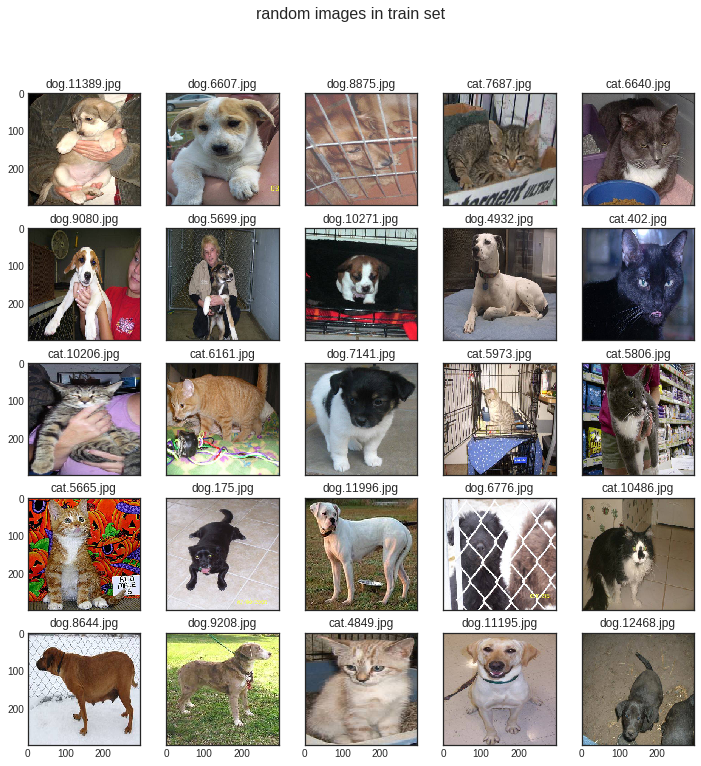

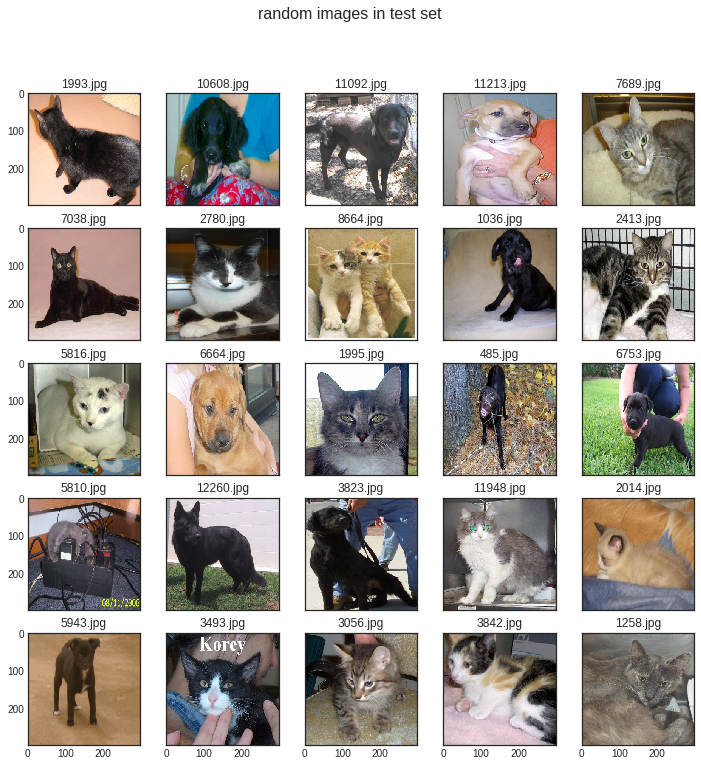

In [12]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(paths, title)
    img_size = (299, 299)
    np.random.seed(20181018)
    randarr = np.random.randint(low=0, high=len(paths), size=25)
    randarr = np.array(randarr).reshape(5, 5)
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(12, 12))
    #fig.canvas.set_window_title(title)
    fig.suptitle(title, fontsize=16)
    for i in range(5):
        for j in range(5):
            index = randarr[i][j]
            path = paths[index]
            img = image.load_img(path, target_size=img_size)
            ax[i,j].set_title(os.path.basename(path))
            ax[i,j].imshow(img)

show_random_images(train_files_paths, 'random images in train set')

show_random_images(test_files_paths, 'random images in test set')

#### 1.2.3 统计图片尺寸范围

In [2]:
train_image_shapes = np.array([cv2.imread(file, 0).shape for file in train_files_paths])
train_image_sizes  = np.array([shape[0] * shape[1] for shape in train_image_shapes])

print("The range of training images width is [{}, {}]"
      .format(min(train_image_shapes[:,0]), max(train_image_shapes[:,0])))
print("The range of training images height is [{}, {}]"
      .format(min(train_image_shapes[:,1]), max(train_image_shapes[:,1])))
print("The range of training imagse area(width*height) is [{}, {}]"
      .format(min(train_image_sizes), max(train_image_sizes)))

The range of training images width is [32, 768]
The range of training images height is [42, 1050]
The range of training imagse area(width*height) is [1900, 785664]


#### 1.2.4 绘制图片尺寸分布图

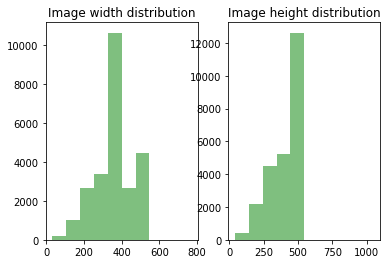

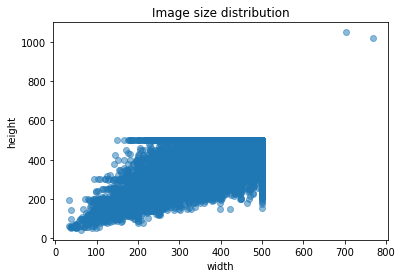

In [25]:
import matplotlib.pyplot as plt

# plot image height, width, area distribution
plt.subplot(121)
plt.hist(train_image_shapes[:,0], alpha=0.5, color=['green'])
plt.title('Image width distribution')

plt.subplot(122)
plt.hist(train_image_shapes[:,1], alpha=0.5, color=['green'])
plt.title('Image height distribution')
plt.show()

#plt.subplot(212)
#plt.hist(train_image_sizes, alpha=0.8, color=['green'])
#plt.plot()
plt.scatter(train_image_shapes[:,0], train_image_shapes[:,1], alpha=0.5)
plt.title('Image size distribution')
plt.xlabel('width')
plt.ylabel('height')

# 调整子图间距
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

#### 1.2.5 绘制类别分布直方图

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_files_labels, alpha=0.5, color=['green'])
plt.title('Image height distribution')
plt.show(plt.title('Image classes distribution\n cat=0, dog=1'))


### 1.3 剔除异常值

经老师指点，这里借鉴了[此处](https://zhuanlan.zhihu.com/p/34068451)的方法，利用预处理模型来剔除异常值。主要思路是，ImageNet 上训练的模型，已具有高精度的图片分类能力，我们可以利用它来预测训练集图片。由于 ImageNet 上的图片类别包含猫和狗，但是按猫和狗又细分有很多类，我们可以提取 ImageNet 分类中的猫和狗的类别，如果预测的结构与提起的类别匹配，则说明该图片有很大可能性是猫或者狗。但是这样话还是有一定误差，怎样减少误差呢？我们还需要结合 ImageNet 的 Top-N 指标。Top-N 的含义是，算法给出 N 个可能的分类，N 分类的概率之和代表正确分类的准确率。我们可以增大 N 的值，来提高匹配猫狗的准确率。

#### 1.3.1 提取 ImageNet 猫狗分类

首先载入从网上下载的 ImageNet 分类 csv 文件，提取其中的猫狗分类。

In [ ]:
import csv
from keras.preprocessing import image
from keras.applications.xception import preprocess_input
from tqdm import tqdm

img_size = (299, 299)

def get_imagenet_classes(file_path):
    dogs = []
    cats = []
    with open(file_path,'r') as f:
        content = csv.reader(f)
        for line in content:
            if line[1] == '狗':
                dogs.append(line[0])
            elif line[1] == '猫':
                cats.append(line[0])
    return (dogs, cats)

# 载入 ImageNet 分类 csv 文件, 获取 dog classes 和 cat classes
dogs_classes, cats_classes = get_imagenet_classes('ImageNetClasses.csv')
imagenet_classes = dogs_classes + cats_classes
print("{} classes, include {} dog classes and {} cat classes"
      .format(len(imagenet_classes), len(dogs_classes), len(cats_classes)))

#### 1.3.2 图片归一化
先读入图片到内存，resize 到 Xcepiton 默认的大小 299 x 299，然后使用 keras 中的 preprocess_input() 函数对图片归一化。

In [19]:
from tqdm import tqdm

image_size = (299, 299)

def read_image_from_path(path):
    img = image.load_img(path, target_size=image_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def read_image_from_paths(paths):
    preprocess_imgs = [read_image_from_path(path) for path in tqdm(paths)]
    return (preprocess_imgs)

# 获取归一化后的图片
preprocess_images = read_image_from_paths(train_files_paths)


 39%|███▉      | 9720/25000 [00:29<00:47, 322.96it/s]


 77%|███████▋  | 19357/25000 [00:58<00:16, 339.60it/s]


100%|██████████| 25000/25000 [01:16<00:00, 327.89it/s]

#### 1.3.3 预测训练集

使用预训练模型预测训练集图片，这里使用在 imagenet 上训练过的 Xception 模型。

In [20]:
from keras.applications.xception import decode_predictions

def do_model_predict(model, imgs, top=10):
    pred = model.predict(imgs)
    return decode_predictions(pred, top=top)[0]

def get_predict_result(model, imgs, top=10):
    result = [do_model_predict(model, x, top) for x in tqdm(imgs)]
    return result
        
base_model = Xception(include_top=True, weights='imagenet')

# 预测训练集
pred = get_predict_result(base_model, preprocess_images, 50)


 15%|█▍        | 3717/25000 [00:32<02:51, 124.37it/s]


 30%|██▉       | 7435/25000 [01:01<02:22, 123.69it/s]


 45%|████▍     | 11140/25000 [01:31<01:51, 124.65it/s]


 59%|█████▉    | 14806/25000 [02:01<01:23, 121.86it/s]


 74%|███████▍  | 18472/25000 [02:31<00:52, 124.23it/s]


 89%|████████▊ | 22138/25000 [03:00<00:23, 124.06it/s]


100%|██████████| 25000/25000 [03:23<00:00, 122.72it/s]

In [30]:
print(np.shape(pred))
print(pred[0])
print(pred[0][0])
print(pred[0][0][0])

(25000, 50, 3)
[('n02099267', 'flat-coated_retriever', 0.7030216), ('n02099712', 'Labrador_retriever', 0.21680924), ('n02099429', 'curly-coated_retriever', 0.02395138), ('n02097130', 'giant_schnauzer', 0.0025443595), ('n02109047', 'Great_Dane', 0.0015482457), ('n02111277', 'Newfoundland', 0.0014072086), ('n02100236', 'German_short-haired_pointer', 0.001326709), ('n02105412', 'kelpie', 0.00094615505), ('n02097209', 'standard_schnauzer', 0.00079727307), ('n02101006', 'Gordon_setter', 0.00065310416), ('n02112706', 'Brabancon_griffon', 0.0006096812), ('n02099849', 'Chesapeake_Bay_retriever', 0.00057336275), ('n04409515', 'tennis_ball', 0.0005610297), ('n02092339', 'Weimaraner', 0.00055696775), ('n02105056', 'groenendael', 0.00048711576), ('n02089078', 'black-and-tan_coonhound', 0.0004840545), ('n02108551', 'Tibetan_mastiff', 0.0004836436), ('n04254680', 'soccer_ball', 0.0004794695), ('n02099601', 'golden_retriever', 0.00047779887), ('n02106550', 'Rottweiler', 0.0004363172), ('n02104365', '

#### 1.3.4 从预测结果提取异常数据

我们使用模型预测训练集，得到了每个图片的的 Top-50 预测结果。对于每个图片，如果 Top-50 分类中有任何一个类别属于猫或者狗，那么这个图片就有一定概率是猫或者狗；反之，如果 Top-50 分类中没有任何一项属于猫或者狗，那么很大地概率这张图片就是非猫非狗的异常值了。

于是，结下来任务就是计算每张图片的 Top-50 分类中，匹配到猫或者狗的类别总数。如果总数为零，就标记为异常数据。

In [49]:
import matplotlib.pyplot as plt

# 获取预测结果中，能匹配到猫狗类型的类别总数
def get_matched_classes_nums_list(pred):
    mathed = []
    # 每一个图片的 top 50 预测结果：
    for item in pred:
        # top 50 中所有的类别
        classes = [x[0] for x in item]
        # 所有的分类中，匹配到猫狗类型的类别总数
        mathed.append(sum([1 for x in classes if x in imagenet_classes]))
    return mathed

matched_classes_nums = get_matched_classes_nums_list(pred)
#print(len(matched_classes_nums))

# 获取异常数据的文件名
def get_unmatched_files_paths(class_nums_list):
    unmatched = []
    for index, value in enumerate(mathed_classes_nums):
        if value == 0:
            unmatched.append(train_files_paths[index])
    return unmatched

unmatched_images_paths = get_unmatched_files_paths(matched_classes_nums)

print("{} images unmathed".format(len(unmatched_images_paths)))

25000
34 images unmathed


####  1.3.5 展示所有未成功匹配到猫狗的图片

通过以上处理，预训练模型识别出了 34 张未正确匹配猫狗图片分类的图片。但是否这些图片真的就是异常值呢？我们可以将其可视化，然后人工校验并筛选一下，确保最终剔除的是真正的异常值。

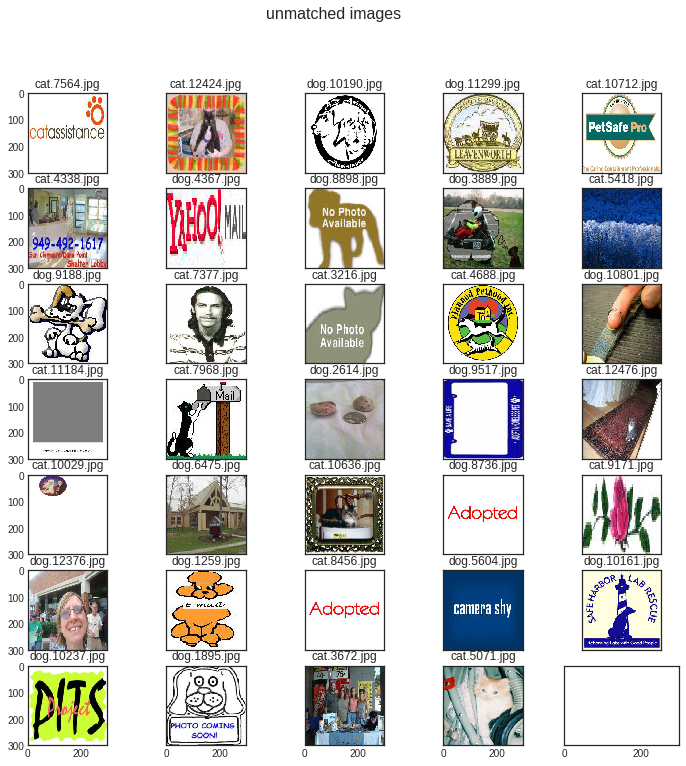

In [59]:
def show_unmatched_images(paths, title):
    image_size = (299, 299)
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(7, 5, sharex='col', sharey='row', figsize=(12, 12))
    fig.suptitle(title, fontsize=16)
    for i in range(7):
        for j in range(5):
            index = i * 5 + j
            if (index < len(paths)):
                path = paths[index]
                img = image.load_img(path, target_size=image_size)
                ax[i, j].set_title(os.path.basename(path))
                ax[i, j].imshow(img)

show_unmatched_images(unmatched_images_paths, "unmatched images")

可以看出，利用 top-50 预测结果，筛选出的未成功匹配猫狗的图片中，大部分都被正确地识别为异常图片，但是也有不少猫或者狗的图片被识别错误。我们需要保留这被错误识别的猫狗图片，然后从训练集中剔除异常值。

#### 1.3.6 移除训练集中的异常图片

In [68]:
# 保存被错误识别的猫狗图片（能看出是猫或者狗）
resolved = ['cat.12424.jpg','dog.8898.jpg','dog.9188.jpg',
            'cat.3216.jpg','cat.7968.jpg','cat.12476.jpg',
            'cat.10636.jpg','dog.1259.jpg','dog.1895.jpg',
            'cat.5071.jpg']

need_remove_images = []
for file_path in unmatched_images_paths:
    file_name = os.path.basename(file_path)
    if file_name not in resolved:
        need_remove_images.append(file_path)

print("{} outliers in train set need to be remove".format(len(need_remove_images)))
print(need_remove_images)


24 outliers in train set need to be remove
['data/train2/cat/cat.7564.jpg', 'data/train2/dog/dog.10190.jpg', 'data/train2/dog/dog.11299.jpg', 'data/train2/cat/cat.10712.jpg', 'data/train2/cat/cat.4338.jpg', 'data/train2/dog/dog.4367.jpg', 'data/train2/dog/dog.3889.jpg', 'data/train2/cat/cat.5418.jpg', 'data/train2/cat/cat.7377.jpg', 'data/train2/cat/cat.4688.jpg', 'data/train2/dog/dog.10801.jpg', 'data/train2/cat/cat.11184.jpg', 'data/train2/dog/dog.2614.jpg', 'data/train2/dog/dog.9517.jpg', 'data/train2/cat/cat.10029.jpg', 'data/train2/dog/dog.6475.jpg', 'data/train2/dog/dog.8736.jpg', 'data/train2/cat/cat.9171.jpg', 'data/train2/dog/dog.12376.jpg', 'data/train2/cat/cat.8456.jpg', 'data/train2/dog/dog.5604.jpg', 'data/train2/dog/dog.10161.jpg', 'data/train2/dog/dog.10237.jpg', 'data/train2/cat/cat.3672.jpg']


In [86]:
# 移除测试集中的异常值，这里并没有真正删除文件，只是对符号链接做 unlink 操作
def unlink_files(paths):
    for file_path in paths:
        if os.path.exists(file_path) and os.path.islink(file_path):
            os.unlink(file_path)

unlink_files(need_remove_images)

### 1.4 图片预处理

#### 1.4.1 重新载入训练集

由于内存有限，重启 kernel 释放内存，然后重新载入剔除异常值后的训练集文件。

In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
import os, cv2
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.applications import Xception

%matplotlib inline

def load_train_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 2) #one-hot encode
    return paths, targets

# 删除异常值后，重新载入训练集图片，并统计图片张数
train_files_paths, train_files_targes = load_train_dataset('data/train2')
train_files_labels = [1 if 'dog' in name else 0 for name in train_files_paths]

train_dogs_paths = [path for path in train_files_paths if 'dog' in path]
train_cats_paths = [path for path in train_files_paths if 'cat' in path]

print("after remove outliers, {} iamges retained，include {} dogs images and {} cats images."
      .format(len(train_files_paths), len(train_dogs_paths), len(train_cats_paths)))

after remove outliers, 24976 iamges retained，include 12487 dogs images and 12489 cats images.


#### 1.4.2 数据增强
使用 keras 的内置 ImageDataGenerator 可以对输入的图片进行数据增强：随机剪切变换，随机缩放，左右、上下翻转，随机旋转一定角度。数据增强是扩充数据集、改善模型效果简单而有效的方法。

In [3]:
from keras.preprocessing.image import ImageDataGenerator

reforce_gen = ImageDataGenerator(shear_range=0.2,      #随机剪切变换强度
                                 zoom_range=0.2,       #随机缩放幅度
                                 rotation_range=45,    #随机旋转角度范围
                                 horizontal_flip=True, #随机左右翻转
                                 vertical_flip=True)   #随机上下翻转
gen = ImageDataGenerator()

batch_size = 16
image_size = (299, 299)

#train_generator = train_gen.flow(X, Y, batch_size=batch_size)
train_generator = gen.flow_from_directory("data/train2", image_size, shuffle=False,
                                          batch_size=16)
test_generator = gen.flow_from_directory("data/test2", image_size, shuffle=False, 
                                         batch_size=25, class_mode=None)

Found 24976 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


从理论上分析，本项目的训练集数据量达到了 25000，规模并不小，所以通过数据增强来获取的提升应该很有限。通过实验发现确实如此，此处的数据增强并没有显著的改善验证集上的表现，相反会使得导致验证集上的损失过大。其可能的原因应该是相关的参数组合不当缘故，由于时间原因未能充分探究。

注：这里暂未对图片直接进行归一化，后续利用 kears 内置的 preprocess_input 函数来处理。

---
<a id='step2'></a>
## 步骤2：搭建模型

这里选取 Keras 提供的几个预训练的模型中比较新且参数数量比较小的 Xception 模型，并使用其在 imagenet 上的预训练权重，使用迁移学习的方法搭建CNN。

如果直接在一个巨大 Xcepiton 模型后面加上全连接层，那么训练 10 代就需要跑十次巨大的网络，而且我们的卷积层都是不可训练的，那么这些计算就是浪费的。所以我们可以将多个不同的网络输出的特征向量先保存下来，以便后续的训练。这样做的好处是一旦保存了特征向量，即使是在普通笔记本上也能轻松训练。

### 2.1 构建基础模型

In [4]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model

input_tensor = Input(shape=(299, 299, 3))
input_tensor = Lambda(xception.preprocess_input)(input_tensor)
base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_con

这里比较重要的步骤，是使用 Keras 内置的 preprocess_input() 函数对输入的图片进行归一化。常用的图片归一化方法有图片缩放、逐样本均值消减和特征标准化。在网上找到了该函数源码，其核心处理过程如下：
```
mean = [103.939, 116.779, 123.68]   
x[..., 0] -= mean[0]  
x[..., 1] -= mean[1]  
x[..., 2] -= mean[2]  
```
可以看到，这里的 preprcess_input 函数采用的方法是对样本执行逐样本均值消减，即在每个维度上减去样本的均值。


### 2.2 使用基础模型进行预测

通过已训练好的imagenet权重对我们的数据进行特征提取，然后再用提取的特征做一个简单的全连接。
从生成器上获取数据并进行预测，返回与 predict_on_batch 输入类似的数据。

In [5]:
train = base_model.predict_generator(train_generator, steps=len(train_generator.filenames) // 16, verbose=1)
test = base_model.predict_generator(test_generator, steps=len(test_generator.filenames) // 25, verbose=1)

500/500 [==============================] - 41s 82ms/step


In [5]:
print(len(train_generator.filenames))
print(len(test_generator.filenames))

24976
12500


### 2.3 保存特征权重

为了后续的训练，这里将输出的特征向量先保存下来。

In [6]:
import h5py

with h5py.File('weights.exception.hdf5', 'w') as f:
    f.create_dataset('train', data = train)
    f.create_dataset('test', data = test)
    f.create_dataset('label', data = train_generator.classes)

### 2.4 导入特征权重

In [7]:
from sklearn.utils import shuffle

X_train = []
X_test = []

with h5py.File('weights.exception.hdf5', 'r') as f:
    X_train.append(np.array(f['train']))
    X_test.append(np.array(f['test']))
    Y_train = np.array(f['label'])
    
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(Y_train.shape)

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(Y_train.shape)

np.random.seed(20181016)
X_train, Y_train = shuffle(X_train, Y_train)

(1, 24976, 2048)
(1, 12500, 2048)
(24976,)
(24976, 2048)
(12500, 2048)
(24976,)


### 2.5 增加 dropout 层及并分类
为了适合本项目猫狗的二分类，将输出层改为二分类的全连接，使用 sigmoid 激活函数。

In [8]:
input_tensor = Input(X_train.shape[1:])
model = Model(input_tensor, Dropout(0.2)(input_tensor))
model = Model(model.input, Dense(1, activation = 'sigmoid')(model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 保存模型架构到文件
with open('xception.json', 'w') as f:
    f.write(model.to_json())

---
<a id='step3'></a>
## 步骤3：训练模型与评估


### 3.1 编译模型

In [10]:
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

### 3.2 训练模型。

为防止过拟合，val_loss 不再下降后的 3 个 epochs 后停止训练

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 30
batch_size = 128

earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='weights.best.xception.hdf5', verbose=1, save_best_only=True)
callback_list = [checkpointer, earlyStopping]
history = model.fit(X_train, Y_train, validation_split = 0.2,
                    epochs = epochs, batch_size = batch_size, verbose=1,
                    callbacks=callback_list)

Train on 19980 samples, validate on 4996 samples
Epoch 1/30
19980/19980 [==============================] - 1s 62us/step - loss: 0.1329 - acc: 0.9843 - val_loss: 0.0449 - val_acc: 0.9918

Epoch 00001: val_loss improved from inf to 0.04490, saving model to weights.best.xception.hdf5
Epoch 2/30
19980/19980 [==============================] - 1s 26us/step - loss: 0.0330 - acc: 0.9936 - val_loss: 0.0266 - val_acc: 0.9930

Epoch 00002: val_loss improved from 0.04490 to 0.02663, saving model to weights.best.xception.hdf5
Epoch 3/30
19980/19980 [==============================] - 1s 26us/step - loss: 0.0228 - acc: 0.9940 - val_loss: 0.0223 - val_acc: 0.9936

Epoch 00003: val_loss improved from 0.02663 to 0.02233, saving model to weights.best.xception.hdf5
Epoch 4/30
19980/19980 [==============================] - 1s 26us/step - loss: 0.0199 - acc: 0.9947 - val_loss: 0.0210 - val_acc: 0.9932

Epoch 00004: val_loss improved from 0.02233 to 0.02102, saving model to weights.best.xception.hdf5
Epoch 5

### 3.3 可视化模型训练过程

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


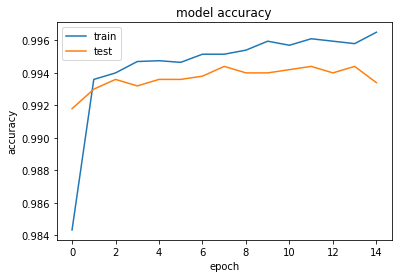

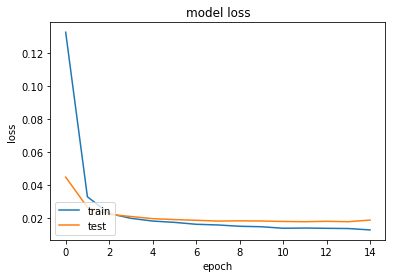

In [12]:
import matplotlib.pyplot as plt
def show_learning_curves(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower left')
    plt.show()

show_learning_curves(history)

### 3.4 探索超参数和优化器
这里主要探索 dropout, batch_size，validation_split 等参数以及不同的优化器对 val_loss 的影响。

为了方便测试不同参数，这里用一个函数将建立模型、编译及训练模型的过程封装成一个函数，参数为可能会尝试的超参数。同时，将比较参数的过程也进行封装，这样就方便比较不同的参数。为了简便直观得看到参数的取值对 val_loss 的影响，这里用 pandas.DataFrame 将对比结果以表格的形式输出。

In [18]:
def specify_model_variables(optimizer='adadelta', dropout=0.2, batch_size=128, validation_split=0.2,
                            verbose=0, plot=False):
    input_tensor = Input(X_train.shape[1:])
    model = Model(input_tensor, Dropout(dropout)(input_tensor))
    model = Model(model.input, Dense(1, activation = 'sigmoid')(model.output))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=verbose, mode='auto')
    checkpointer = ModelCheckpoint(filepath='weights.best.xception.hdf5', verbose=verbose, save_best_only=True)
    callback_list = [checkpointer, earlyStopping]
    history = model.fit(X_train, Y_train, validation_split = validation_split,
                        epochs = 30, batch_size = batch_size, verbose=verbose,
                        callbacks=callback_list)
    if (plot == True):
        show_learning_curves(history)
    return (history.history['val_loss'], history.history['val_acc'])

def compare_model_variables(option_name, options_list):
    data = []
    for item in options_list:
        if (option_name == 'optimizer'):
            val_loss, val_acc = specify_model_variables(optimizer=item)
        elif (option_name == 'dropout'):
            val_loss, val_acc = specify_model_variables(dropout=item)
        elif (option_name == 'batch_size'):
            val_loss, val_acc = specify_model_variables(batch_size=item)
        elif (option_name == 'validation_split'):
            val_loss, val_acc = specify_model_variables(validation_split=item)
        else:
            print("unsupport option")
            return
        
        row = []
        row.append(np.average(val_loss))
        row.append(np.max(val_loss))
        row.append(np.min(val_loss))
        data.append(row)
    
    val_loss = pd.DataFrame(
        data=data,
        index=options_list,
        columns=['Avg', 'Max', 'Min']
    )
    val_loss.index.name = option_name
    return val_loss

#### 3.4.1 探索不同的优化器

In [77]:
df = compare_model_variables('optimizer', ['adam', 'adadelta', 'rmsprop'])
df

,Avg,Max,Min
optimizer,,,
adam,0.021688,0.047435,0.018209
adadelta,0.021515,0.046990,0.018312
rmsprop,0.020502,0.030503,0.018504


#### 3.4.2 探索不同的 dropout

In [82]:
df = compare_model_variables('dropout', np.arange(0.1,1,0.1))
df

,Avg,Max,Min
dropout,,,
0.1,0.022773,0.046502,0.018423
0.2,0.020875,0.044995,0.017899
0.3,0.021292,0.046482,0.018134
0.4,0.022200,0.047580,0.018439
0.5,0.021597,0.047966,0.018381
0.6,0.022298,0.049096,0.018599
0.7,0.023776,0.050966,0.019483
0.8,0.024109,0.055757,0.019904
0.9,0.028104,0.063775,0.021970


#### 3.4.3 探索不同的 batch_size

In [85]:
df = compare_model_variables("batch_size", [8, 16, 32, 64, 128, 256, 512])
df

,Avg,Max,Min
batch_size,,,
8,0.021103,0.022001,0.020289
16,0.020759,0.025029,0.019336
32,0.019999,0.025877,0.018281
64,0.019947,0.029395,0.018326
128,0.021786,0.045531,0.018243
256,0.026464,0.082115,0.018735
512,0.028462,0.133027,0.018280


#### 3.4.4 探索不同的验证集分割比例

In [86]:
compare_model_variables("validation_split", np.arange(0.1,1,0.1))

,Avg,Max,Min
validation_split,,,
0.1,0.026785,0.046564,0.023572
0.2,0.022156,0.047203,0.018543
0.3,0.020213,0.053555,0.016921
0.4,0.022366,0.061218,0.018430
0.5,0.021956,0.066335,0.017545
0.6,0.023609,0.086893,0.017971
0.7,0.025489,0.112159,0.018107
0.8,0.031141,0.148452,0.019859
0.9,0.048170,0.262581,0.021368


### 3.5 模型评估

通过以上探索，我们选择其中一组最佳参数，来对模型进行训练。

Train on 17483 samples, validate on 7493 samples
Epoch 1/30
17483/17483 [==============================] - 2s 134us/step - loss: 0.0695 - acc: 0.9876 - val_loss: 0.0252 - val_acc: 0.9933

Epoch 00001: val_loss improved from inf to 0.02517, saving model to weights.best.xception.hdf5
Epoch 2/30
17483/17483 [==============================] - 2s 98us/step - loss: 0.0228 - acc: 0.9941 - val_loss: 0.0197 - val_acc: 0.9947

Epoch 00002: val_loss improved from 0.02517 to 0.01972, saving model to weights.best.xception.hdf5
Epoch 3/30
17483/17483 [==============================] - 2s 98us/step - loss: 0.0188 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9947

Epoch 00003: val_loss improved from 0.01972 to 0.01779, saving model to weights.best.xception.hdf5
Epoch 4/30
17483/17483 [==============================] - 2s 98us/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0169 - val_acc: 0.9945

Epoch 00004: val_loss improved from 0.01779 to 0.01693, saving model to weights.best.xception.hdf5
Epoch 

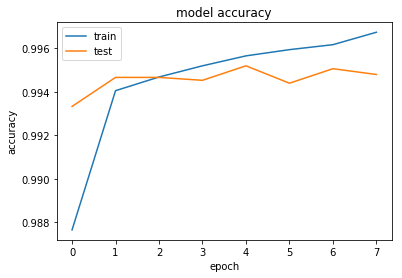

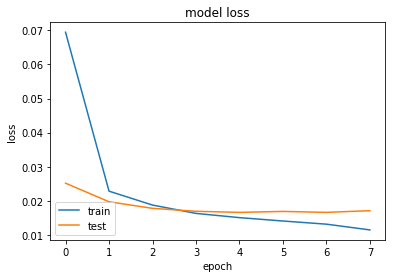

([0.025167894722185617,
  0.019717257648856006,
  0.01778702723624504,
  0.01692752731813167,
  0.016602829921118462,
  0.016884541036786355,
  0.016605569460068158,
  0.017103169323607642],
 [0.9933271052982784,
  0.9946616842386227,
  0.9946616842386227,
  0.9945282263445883,
  0.9951955158147604,
  0.9943947684505539,
  0.995062057920726,
  0.9947951421326572])

In [20]:
specify_model_variables(optimizer='adam', dropout=0.2, batch_size=32, validation_split=0.3, verbose=1, plot=True)

---
<a id='step4'></a>
## 步骤 4: 模型预测



这里从别处借鉴了小技巧，将每个预测值限制到了 [0.005, 0.995] 的区间内。因为 kaggle 官方的评估标准是 LogLoss：
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$  
对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，相当于 15 和 2 的差别。

上面训练过程中保存了最佳的权重，将模型的架构保存为 json 文件。因此后续预测的时候，只需要从 json 加载模型，并 load 权重即可。

### 4.1 加载模型及权重

In [ ]:
from tqdm import tqdm
from keras.models import model_from_json

with open('xception.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('weights.best.xception.hdf5')

with h5py.File('weights.exception.hdf5', 'r') as f:
    X_test.append(np.array(f['test']))

### 4.2 预测测试集

In [27]:
y_pred = model.predict(X_test, verbose=1)
y_pred_clip = y_pred.clip(min = 0.005, max = 0.995)

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("data/test2", (229, 229), shuffle=False,
                                         batch_size=16, class_mode=None)

12500/12500 [==============================] - 0s 29us/step
Found 12500 images belonging to 1 classes.


### 4.3 保存预测结果

In [30]:
from tqdm import tqdm
def save_predictions_as_csv(predictions, file_name):
    df = pd.read_csv("sample_submission.csv")
    for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        df.set_value(index-1, 'label', predictions[i])
    df.to_csv(file_name, index=None)
    df.head(10)

save_predictions_as_csv(y_pred, 'DogsVsCatsPredictOrigin.csv')
save_predictions_as_csv(y_pred_clip, 'DogsVsCatsPredictClip.csv')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


### 4.4 Kaggle 得分及排名 

通过上述探索及优化，在最终将 Kaggle 得分提升到了 0.04182，在 Public Leaderboard 上排名为 20/1314，到达了 kaggle 前 10% 的项目目标。

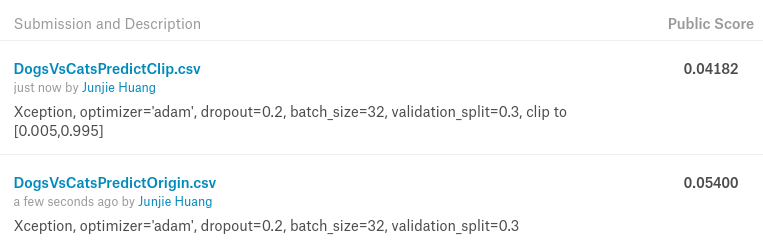

---
<a id='step5'></a>
## 步骤5：模型可视化

In [1]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_json
from keras.utils import plot_model

with open('xception.json', 'r') as f:
    model = model_from_json(f.read())

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 将模型结构保存为图片：
plot_model(model, to_file='model.png')

Using TensorFlow backend.


### 展示模型的在测试集上的分类结果

16


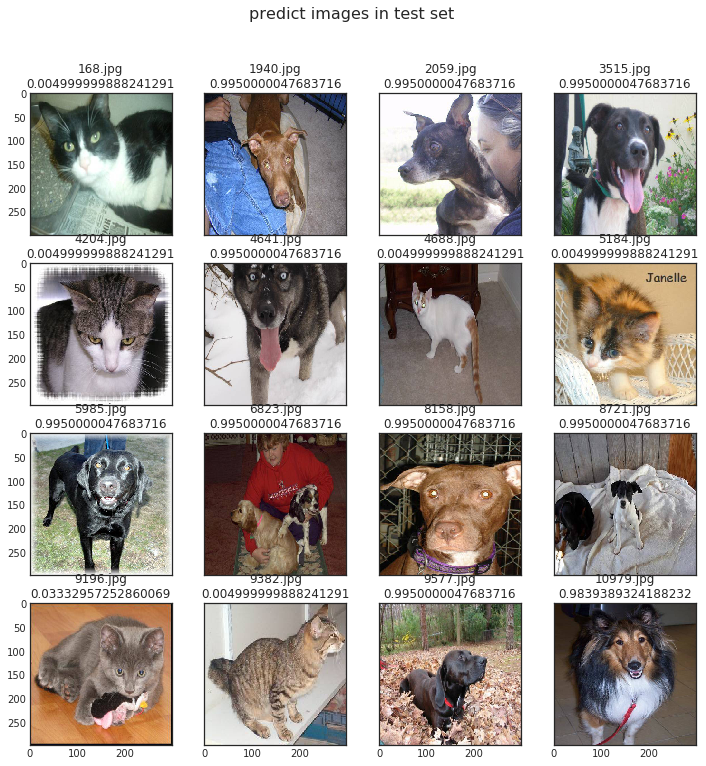

In [2]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import csv
import os

%matplotlib inline

def show_random_train_images(title):
    img_size = (299, 299)
    np.random.seed(20181018)
    randarr = np.random.randint(low=0, high=12500, size=16)
    scorearr = []
    indexarr = []
    with open('DogsVsCatsPredictClip.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[0] != 'id' and int(row[0]) in randarr:
                indexarr.append(int(row[0]))
                scorearr.append(row[1])
    print(len(scorearr))
    patharr = ["data/test/%s.jpg" % i for i in indexarr]
    plt.style.use('seaborn-white')
    fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
    #fig.canvas.set_window_title(title)
    fig.suptitle(title, fontsize=16)
    for i in range(4):
        for j in range(4):
            index = i * 4 + j
            path = patharr[index]
            img = image.load_img(path, target_size=img_size)
            ax[i,j].set_title(os.path.basename(path) + '\n' + scorearr[index] )
            ax[i,j].imshow(img)
            
show_random_train_images('predict images in test set')

## 参考文献  
1. [深度学习——分类之Xception和卷积的分组](https://zhuanlan.zhihu.com/p/32965380)
2. [手把手教你如何在Kaggle猫狗大战冲到Top2%](https://zhuanlan.zhihu.com/p/25978105)
3. [Keras Image Data Augmentation 各参数详解](https://zhuanlan.zhihu.com/p/30197320)